In [90]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import pandas as pd
import numpy as np

data_df = pd.read_csv('../datasets/PstP/PstP_LifeChem_Screen_cpds_only.csv.gz')
data_df.columns = ['Molecule ID', 'PubChem_CID', 'SMILES']
ata_info = pd.read_csv('../datasets/PstP/ata.smi', header=None, delimiter=' ')

ata_info.columns = ['SMILES', 'Molecule ID']
ata_info['PubChem_CID'] = ata_info['Molecule ID']
ata_info = ata_info[['Molecule ID', 'PubChem_CID', 'SMILES']]

data_df = pd.concat([data_df, ata_info]).reset_index(drop=True)
data_df['Index ID'] = np.arange(data_df.shape[0])
data_df = data_df[['Index ID', 'Molecule ID', 'PubChem_CID', 'SMILES']]

print('Library size: {}'.format(data_df.shape))

Library size: (94044, 4)


In [91]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.FilterCatalog import *

saltRemover = SaltRemover(defnFilename='../datasets/Salts.txt')
FP_radius=2
FP_size=1024

rdkit_mols = data_df['SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_mols = rdkit_mols.apply((lambda x: saltRemover.StripMol(x)))
data_df['rdkit SMILES'] = rdkit_mols.apply((lambda x: Chem.MolToSmiles(x)))
data_df['1024 MorganFP Radius 2'] = rdkit_mols.apply((lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 
                                                                                                      radius=FP_radius, 
                                                                                                      nBits=FP_size).ToBitString()))



In [92]:
duplicates = data_df[data_df['rdkit SMILES'].duplicated()]
duplicates = data_df[data_df['rdkit SMILES'].isin(duplicates['rdkit SMILES'])]
duplicates.to_csv('../pstp_duplicates.csv.gz', index=False)

In [94]:
# drop duplicates
print('Library BEFORE deduplication: {}'.format(data_df.shape))
data_df.to_csv('../datasets/pstp_all.csv.gz', index=False)
data_df = data_df.drop_duplicates(subset='rdkit SMILES', keep='first')
print('Library AFTER deduplication: {}'.format(data_df.shape))

Library BEFORE deduplication: (94044, 6)
Library AFTER deduplication: (93949, 6)


---
# Process Clustering

In [2]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import pandas as pd
import numpy as np

data_df = pd.read_csv('../datasets/PstP/pstp_all.csv.gz')
c2 = np.memmap('../datasets/PstP/cluster_assigment_vector_0.2.dat', 
                mode='r', dtype='int32', shape=(data_df.shape[0],))
c2_df = pd.DataFrame(data=np.vstack([c2, np.arange(c2.shape[0])]).T,
                     columns=['Cluster_0.2', 'Index ID'])
c3 = np.memmap('../datasets/PstP/cluster_assigment_vector_0.3.dat', 
                mode='r', dtype='int32', shape=(data_df.shape[0],))
c3_df = pd.DataFrame(data=np.vstack([c3, np.arange(c3.shape[0])]).T,
                     columns=['Cluster_0.3', 'Index ID'])
c4 = np.memmap('../datasets/PstP/cluster_assigment_vector_0.4.dat', 
                mode='r', dtype='int32', shape=(data_df.shape[0],))
c4_df = pd.DataFrame(data=np.vstack([c4, np.arange(c4.shape[0])]).T,
                     columns=['Cluster_0.4', 'Index ID'])

cl2 = np.memmap('../datasets/PstP/cluster_leader_idx_vector_0.2.dat', 
                mode='r', dtype='int32', shape=(data_df.shape[0],))
cl2_df = pd.DataFrame(data=np.vstack([cl2, np.arange(cl2.shape[0])]).T,
                     columns=['Cluster_0.2_leader_idx', 'Index ID'])
cl3 = np.memmap('../datasets/PstP/cluster_leader_idx_vector_0.3.dat', 
                mode='r', dtype='int32', shape=(data_df.shape[0],))
cl3_df = pd.DataFrame(data=np.vstack([cl3, np.arange(cl3.shape[0])]).T,
                     columns=['Cluster_0.3_leader_idx', 'Index ID'])
cl4 = np.memmap('../datasets/PstP/cluster_leader_idx_vector_0.4.dat', 
                mode='r', dtype='int32', shape=(data_df.shape[0],))
cl4_df = pd.DataFrame(data=np.vstack([cl4, np.arange(cl4.shape[0])]).T,
                     columns=['Cluster_0.4_leader_idx', 'Index ID'])

In [13]:
merge_df = pd.merge(data_df, c2_df, how='inner', on='Index ID')
merge_df = pd.merge(merge_df, cl2_df, how='inner', on='Index ID')
merge_df = pd.merge(merge_df, c3_df, how='inner', on='Index ID')
merge_df = pd.merge(merge_df, cl3_df, how='inner', on='Index ID')
merge_df = pd.merge(merge_df, c4_df, how='inner', on='Index ID')
merge_df = pd.merge(merge_df, cl4_df, how='inner', on='Index ID')

merge_df.to_csv('../datasets/PstP/pstp_all.csv.gz', index=False)

Cluster counts for 0.2: 86225
Cluster counts for 0.3: 63804
Cluster counts for 0.4: 29050


In [37]:
data_df = pd.read_csv('../datasets/PstP/pstp_all.csv.gz')

for cutoff in [0.2, 0.3, 0.4]:
    clusters, counts = np.unique(data_df['Cluster_{}'.format(cutoff)].values, return_counts=True)
    singletons = np.where(counts == 1)[0].shape[0]
    print('Cutoff {}. Cluster count: {}. Singletons: {}.'.format(cutoff, clusters.shape[0], singletons))

Cutoff 0.2. Cluster count: 86225. Singletons: 81063.
Cutoff 0.3. Cluster count: 63804. Singletons: 51715.
Cutoff 0.4. Cluster count: 29050. Singletons: 15705.


In [108]:
data_df = pd.read_csv('../datasets/PstP/pstp_all.csv.gz')

for cutoff in [0.2, 0.3, 0.4]:
    clusters, counts = np.unique(data_df['BT_{} ID Leader'.format(cutoff)].values, return_counts=True)
    singletons = np.where(counts == 1)[0].shape[0]
    print('Cutoff {}. Cluster count: {}. Singletons: {}.'.format(cutoff, clusters.shape[0], singletons))
    
data_df[data_df['Molecule'].str.contains('ATA')]

Cutoff 0.2. Cluster count: 86225. Singletons: 81063.
Cutoff 0.3. Cluster count: 63804. Singletons: 51715.
Cutoff 0.4. Cluster count: 29050. Singletons: 15705.


,Index ID,Molecule,PubChem_CID,SMILES,rdkit SMILES,Morgan FP_2_1024,BT_0.2 ID,BT_0.2 ID Leader,BT_0.3 ID,BT_0.3 ID Leader,BT_0.4 ID,BT_0.4 ID Leader,PstP Activity
55009,55009,CID2259_ATA,CID2259_ATA,C1=CC(=C(C=C1C(=C2C=CC(=O)C(=C2)C(=O)O)C3=CC(=...,O=C(O)C1=CC(=C(c2ccc(O)c(C(=O)O)c2)c2ccc(O)c(C...,0000000000000000000000010000000000000000000000...,99205,55009,106132,55009,107388,55009,NaN


---
# Generate Diverse Plate

In [110]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import pandas as pd
import numpy as np

data_df = pd.read_csv('../datasets/PstP/pstp_all.csv.gz')
#select plate of diverse cpds
num_cpds = 80
cpds_to_select = [55009] # select first cpd as ATA

X_fps = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in data_df['Morgan FP_2_1024']]).astype(float)
for i in range(1, num_cpds):
    X_curr_selected = X_fps[cpds_to_select,:]
    remaining_cpds = np.setdiff1d(np.arange(X_fps.shape[0]), cpds_to_select)
    X_rem = X_fps[remaining_cpds,:]
    tandist = pairwise_distances(X_rem, X_curr_selected, metric='jaccard')
    farthest_idx = np.argmax(tandist.mean(axis=1)) 
    
    cpds_to_select.append(remaining_cpds[farthest_idx])

In [2]:
diverse_plate = data_df[data_df['Index ID'].isin(cpds_to_select)]
diverse_plate = diverse_plate.sample(frac=1)
print('Diverse plate size: {}'.format(diverse_plate.shape))

Diverse plate size: (80, 12)


In [112]:
diverse_plate.to_csv('../datasets/PstP/diverse_plate.csv', index=False)

In [111]:
diverse_plate

,Index ID,Molecule,PubChem_CID,SMILES,rdkit SMILES,Morgan FP_2_1024,BT_0.2 ID,BT_0.2 ID Leader,BT_0.3 ID,BT_0.3 ID Leader,BT_0.4 ID,BT_0.4 ID Leader,PstP Activity
0,690,SMSSF-0616545,71809363,O=S(=O)(C1CN(C1)S(=O)(=O)C1CC1)C1CCCCC1,O=S(=O)(C1CCCCC1)C1CN(S(=O)(=O)C2CC2)C1,0010100000000000000000000000000000000000000000...,5852,690,12779,690,14035,690,NaN
1,3,SMSSF-0617232,138546,C1CC2NC1CC=C2,C1=CC2CCC(C1)N2,0000000000000000000000000000000000100000000010...,5165,3,12092,3,13348,3,NaN
2,21898,SMSSF-0552787,46783893,F[B-](F)(F)F.CCCCN1\C(=C\C=C\C=C\C2=[N+](CCCC)...,CCCCn1/c(=C/C=C/C=C/C2=[N+](CCCC)c3ccc(Cl)c4cc...,0001000000000001000000000000000001000000000001...,27060,21898,33987,21898,35243,21898,NaN
3,92809,SMSSF-0016869,7513037,COC1=CC2=C(C=C1OC)N=C(NC1=NC3=C(S1)C=C(C)C=C3C)S2,COc1cc2nc(Nc3nc4c(C)cc(C)cc4s3)sc2cc1OC,0000000000000000000000000000000001000000000000...,97971,92809,104898,92809,106154,92809,NaN
4,64158,SMSSF-0045793,3673434,[H]N(C1=[N+](CC2=CC=CO2)C(=CS1)C1=CC=CC=C1)C1=...,c1ccc(Nc2scc(-c3ccccc3)[n+]2Cc2ccco2)cc1,0000000000000000000000000000000000000000000000...,69320,64158,76247,64158,77503,64158,NaN
5,65564,SMSSF-0044387,25332,NC1C2CC3CC(C2)CC1C3,NC1C2CC3CC(C2)CC1C3,0000000000000000000000000000000000000000000000...,70726,65564,77653,65564,78909,65564,NaN
6,49146,SMSSF-0060805,6894308,BrC1=CC=C(\C=N\N=C\C2=CC=C(Br)C=C2)C=C1,Brc1ccc(/C=N/N=C/c2ccc(Br)cc2)cc1,0000000000000000000000000100000000000000000000...,54308,49146,61235,49146,62491,49146,NaN
7,68575,SMSSF-0041376,2140171,ClC(Cl)(Cl)C(=N/P(=S)(N1CCOCC1)N1CCOCC1)\N1CCOCC1,S=P(/N=C(/N1CCOCC1)C(Cl)(Cl)Cl)(N1CCOCC1)N1CCOCC1,0000000000010000000000000000000000000000000000...,73737,68575,80664,68575,81920,68575,NaN
8,68986,SMSSF-0040965,718273,OC1=NN=NC2=C1C1=C(CCCC1)S2,Oc1nnnc2sc3c(c12)CCCC3,0000101000000000000000000100000000000000001000...,74148,68986,81075,68986,82331,68986,NaN
9,50787,SMSSF-0059164,3237180,OC(C(F)(F)C(F)(F)C(F)(F)C(F)F)P(O)(O)=O,O=P(O)(O)C(O)C(F)(F)C(F)(F)C(F)(F)C(F)F,0100000000000000000000000010000000000000000000...,55949,50787,62876,50787,64132,50787,NaN


In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import pandas as pd
import numpy as np

data_df = pd.read_csv('../datasets/PstP/pstp_all.csv.gz')
diverse_plate = pd.read_csv('../datasets/PstP/diverse_plate.csv')
selected_plate = pd.read_csv('../datasets/PstP/iter_0_new.csv')
X_fps = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in data_df['Morgan FP_2_1024']]).astype(float)

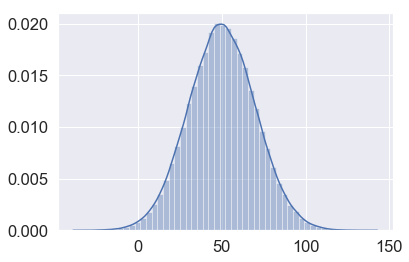

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

# generate normal distributed inhib scores
inhib_scores = np.random.normal(loc=50.0, scale=20.0, size=data_df.shape[0])
sns.distplot(inhib_scores)

In [35]:
x = """ 1  -rw-r--r-- 1 alnammi alnammi     0 May 16 01:03 HS_ClusterBasedRandom_TASK_pcba-aid485281_BATCH_0_START_0_ITERS_0_out.tar.gz
     2  -rw-r--r-- 1 alnammi alnammi     0 May 15 21:20 HS_ClusterBasedRandom_TASK_pcba-aid624288_BATCH_0_START_8_ITERS_0_out.tar.gz
     3  -rw-r--r-- 1 alnammi alnammi     0 May 15 21:46 HS_ClusterBasedRandom_TASK_pcba-aid924_BATCH_0_START_allinactive0_ITERS_0_out.tar.gz
     4  -rw-r--r-- 1 alnammi alnammi     0 May 19 19:14 HS_ClusterBasedWCSelector_55_TASK_pcba-aid540276_BATCH_0_START_5_ITERS_0_out.tar.gz
     5  -rw-r--r-- 1 alnammi alnammi     0 May 20 18:28 HS_ClusterBasedWCSelector_55_TASK_pcba-aid602310_BATCH_0_START_3_ITERS_0_out.tar.gz
     6  -rw-r--r-- 1 alnammi alnammi     0 May 21 13:40 HS_ClusterBasedWCSelector_609_TASK_pcba-aid2147_BATCH_0_START_3_ITERS_0_out.tar.gz
     7  -rw-r--r-- 1 alnammi alnammi     0 May 21 13:53 HS_ClusterBasedWCSelector_609_TASK_pcba-aid2675_BATCH_0_START_3_ITERS_0_out.tar.gz
     8  -rw-r--r-- 1 alnammi alnammi     0 May 21 12:54 HS_ClusterBasedWCSelector_609_TASK_pcba-aid485290_BATCH_0_START_2_ITERS_0_out.tar.gz
     9  -rw-r--r-- 1 alnammi alnammi     0 May 21 11:52 HS_ClusterBasedWCSelector_609_TASK_pcba-aid504332_BATCH_0_START_1_ITERS_0_out.tar.gz
    10  -rw-r--r-- 1 alnammi alnammi     0 May 21 14:03 HS_ClusterBasedWCSelector_609_TASK_pcba-aid504706_BATCH_0_START_3_ITERS_0_out.tar.gz
    11  -rw-r--r-- 1 alnammi alnammi     0 May 21 15:18 HS_ClusterBasedWCSelector_609_TASK_pcba-aid602179_BATCH_0_START_4_ITERS_0_out.tar.gz
    12  -rw-r--r-- 1 alnammi alnammi     0 May 21 14:15 HS_ClusterBasedWCSelector_609_TASK_pcba-aid602233_BATCH_0_START_3_ITERS_0_out.tar.gz
    13  -rw-r--r-- 1 alnammi alnammi     0 May 21 14:54 HS_ClusterBasedWCSelector_609_TASK_pcba-aid602310_BATCH_0_START_4_ITERS_0_out.tar.gz
    14  -rw-r--r-- 1 alnammi alnammi     0 May 21 14:34 HS_ClusterBasedWCSelector_609_TASK_pcba-aid602313_BATCH_0_START_4_ITERS_0_out.tar.gz
    15  -rw-r--r-- 1 alnammi alnammi     0 May 21 12:02 HS_ClusterBasedWCSelector_609_TASK_pcba-aid624287_BATCH_0_START_1_ITERS_0_out.tar.gz
    16  -rw-r--r-- 1 alnammi alnammi     0 May 21 12:13 HS_ClusterBasedWCSelector_609_TASK_pcba-aid624291_BATCH_0_START_1_ITERS_0_out.tar.gz
    17  -rw-r--r-- 1 alnammi alnammi     0 May 21 12:23 HS_ClusterBasedWCSelector_609_TASK_pcba-aid652106_BATCH_0_START_1_ITERS_0_out.tar.gz
    18  -rw-r--r-- 1 alnammi alnammi     0 May 21 16:10 HS_ClusterBasedWCSelector_609_TASK_pcba-aid743266_BATCH_0_START_2_ITERS_0_out.tar.gz
    19  -rw-r--r-- 1 alnammi alnammi     0 May 21 13:27 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid1468_BATCH_0_START_3_ITERS_0_out.tar.gz
    20  -rw-r--r-- 1 alnammi alnammi     0 May 21 16:21 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid2101_BATCH_0_START_5_ITERS_0_out.tar.gz
    21  -rw-r--r-- 1 alnammi alnammi     0 May 21 17:00 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid485290_BATCH_0_START_5_ITERS_0_out.tar.gz
    22  -rw-r--r-- 1 alnammi alnammi     0 May 21 11:11 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid485294_BATCH_0_START_1_ITERS_0_out.tar.gz
    23  -rw-r--r-- 1 alnammi alnammi     0 May 21 13:05 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid485364_BATCH_0_START_2_ITERS_0_out.tar.gz
    24  -rw-r--r-- 1 alnammi alnammi     0 May 21 11:21 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid485367_BATCH_0_START_1_ITERS_0_out.tar.gz
    25  -rw-r--r-- 1 alnammi alnammi     0 May 21 16:44 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid492947_BATCH_0_START_5_ITERS_0_out.tar.gz
    26  -rw-r--r-- 1 alnammi alnammi     0 May 21 12:32 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid504891_BATCH_0_START_2_ITERS_0_out.tar.gz
    27  -rw-r--r-- 1 alnammi alnammi     0 May 21 17:53 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid504891_BATCH_0_START_5_ITERS_0_out.tar.gz
    28  -rw-r--r-- 1 alnammi alnammi     0 May 21 13:17 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid540276_BATCH_0_START_3_ITERS_0_out.tar.gz
    29  -rw-r--r-- 1 alnammi alnammi     0 May 21 17:38 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid588456_BATCH_0_START_5_ITERS_0_out.tar.gz
    30  -rw-r--r-- 1 alnammi alnammi     0 May 20 16:57 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid602310_BATCH_0_START_3_ITERS_0_out.tar.gz
    31  -rw-r--r-- 1 alnammi alnammi     0 May 21 14:24 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid624291_BATCH_0_START_4_ITERS_0_out.tar.gz
    32  -rw-r--r-- 1 alnammi alnammi     0 May 21 16:33 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid624417_BATCH_0_START_5_ITERS_0_out.tar.gz
    33  -rw-r--r-- 1 alnammi alnammi     0 May 21 17:22 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid651635_BATCH_0_START_5_ITERS_0_out.tar.gz
    34  -rw-r--r-- 1 alnammi alnammi     0 May 21 18:06 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid652106_BATCH_0_START_5_ITERS_0_out.tar.gz
    35  -rw-r--r-- 1 alnammi alnammi     0 May 21 12:43 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid720709_BATCH_0_START_2_ITERS_0_out.tar.gz
    36  -rw-r--r-- 1 alnammi alnammi     0 May 20 16:55 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid743255_BATCH_0_START_3_ITERS_0_out.tar.gz
    37  -rw-r--r-- 1 alnammi alnammi     0 May 21 11:42 HS_ClusterBasedWCSelector_custom_1_TASK_pcba-aid743266_BATCH_0_START_1_ITERS_0_out.tar.gz
    38  -rw-r--r-- 1 alnammi alnammi     0 May 16 20:39 HS_InstanceBasedRandom_TASK_pcba-aid485349_BATCH_0_START_7_ITERS_0_out.tar.gz
    39  -rw-r--r-- 1 alnammi alnammi     0 May 21 15:05 HS_InstanceBasedRandom_TASK_pcba-aid652104_BATCH_0_START_5_ITERS_0_out.tar.gz
    40  -rw-r--r-- 1 alnammi alnammi     0 May 15 19:50 HS_MABSelector_2_TASK_pcba-aid1030_BATCH_0_START_6_ITERS_0_out.tar.gz
    41  -rw-r--r-- 1 alnammi alnammi     0 May 15 20:51 HS_MABSelector_2_TASK_pcba-aid1379_BATCH_0_START_6_ITERS_0_out.tar.gz
    42  -rw-r--r-- 1 alnammi alnammi     0 May 15 23:33 HS_MABSelector_2_TASK_pcba-aid602332_BATCH_0_START_6_ITERS_0_out.tar.gz"""

x = x.split('\n')
for a in x:
    b = a.split()[-1][:-19]
    strat = b.split('HS_')[-1].split('_TASK')[0]
    task = b.split('TASK_')[-1].split('_BATCH')[0]
    start = b.split('START_')[-1]
    
    sclass = 'benchmarks'
    if strat == 'ClusterBasedWCSelector_custom_1':
        sclass = 'custom_cbws'
    elif strat in ['ClusterBasedWCSelector_609', 'ClusterBasedWCSelector_55']:
        sclass = 'sampled_hyparams'
        
    f = './params_results/{}/{}/{}/{}/'.format(sclass, strat, task, start)
    
    line1 = 'mkdir -p {} > /dev/null'.format(f)
    line2 = 'tar -czvf {}_ITERS_0_out.tar.gz {} > /dev/null'.format(b, f)

    print('{}\n{}\n'.format(line1, line2))

mkdir -p ./params_results/benchmarks/ClusterBasedRandom/pcba-aid485281/0/ > /dev/null
tar -czvf HS_ClusterBasedRandom_TASK_pcba-aid485281_BATCH_0_START_0_ITERS_0_out.tar.gz ./params_results/benchmarks/ClusterBasedRandom/pcba-aid485281/0/ > /dev/null

mkdir -p ./params_results/benchmarks/ClusterBasedRandom/pcba-aid624288/8/ > /dev/null
tar -czvf HS_ClusterBasedRandom_TASK_pcba-aid624288_BATCH_0_START_8_ITERS_0_out.tar.gz ./params_results/benchmarks/ClusterBasedRandom/pcba-aid624288/8/ > /dev/null

mkdir -p ./params_results/benchmarks/ClusterBasedRandom/pcba-aid924/allinactive0/ > /dev/null
tar -czvf HS_ClusterBasedRandom_TASK_pcba-aid924_BATCH_0_START_allinactive0_ITERS_0_out.tar.gz ./params_results/benchmarks/ClusterBasedRandom/pcba-aid924/allinactive0/ > /dev/null

mkdir -p ./params_results/sampled_hyparams/ClusterBasedWCSelector_55/pcba-aid540276/5/ > /dev/null
tar -czvf HS_ClusterBasedWCSelector_55_TASK_pcba-aid540276_BATCH_0_START_5_ITERS_0_out.tar.gz ./params_results/sampled_hypar

'6'

In [33]:
b

'HS_MABSelector_2_TASK_pcba-aid602332_BATCH_0_START_6'